In [1]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
dpi=150

import numpy as np
import oxyba as ox
from importlib import reload; reload(ox);
from sklearn.model_selection import train_test_split

### Generate correlated random numbers

Both variables are standardized $Y\sim N(0,1)$ and $X \sim N(0,1)$.
Therefore, the regression model $y = \beta_0 = \beta_1 X + \epsilon$ 
should have an intercept $\beta_0 = 0$

In [2]:
N = 1000
np.random.seed(23)
data = np.random.normal(loc=[0.0, 0.0], scale=[1.0, 1.0], size=(N,2))

Make it correlated with $\rho=.5$. 
Thus the regression coefficient should be estimated as $\beta_1 = 0.5$.

In [3]:
data = ox.rand_bivar(data, .5)

A little check what $\rho$ can be computed from this fake dataset

In [4]:
rho,_ = ox.corr(data)
rho = rho[0][1]
print("Beta1 coefficient is expected to be: ", rho)

Beta1 coefficient is expected to be:  0.5148436623550902


### Prepare y and X

Define `y` and `X` in python. Ones are added to `X` for the intercept estimation.

In [5]:
y = data[:,0]
X = np.c_[np.ones((len(y),1)), data[:,1]]

### Estimate Parameters

Run the MLE estimation. The results looks similar to what is expected.

In [6]:
beta = ox.linreg_ridge_lu(y,X, 5.0)
print(beta)

[-0.03411307  0.49109658]


Let's compare it againts OLS regression.

In [7]:
print(ox.linreg_ols_lu(y,X))

[-0.03418674  0.49344386]


### Hyperparameter lambda
The hyperparameter $\lambda$ penalize the absolute value of an estimated parameter. 

* $\lambda = 0$ : it's simple linear regression
* $0 < \lambda < \infty$ : estimated parameters will shrink the larger $\lambda$
* $\lambda = \infty$ : paramters are zero



If you compute an error function (e.g. RMSE) on the training sample or resp in-sample
then OLS or $\lambda=0$ will perform best. 
This is kind of expected as OLS fit the RMSE best by modeling assumptions.

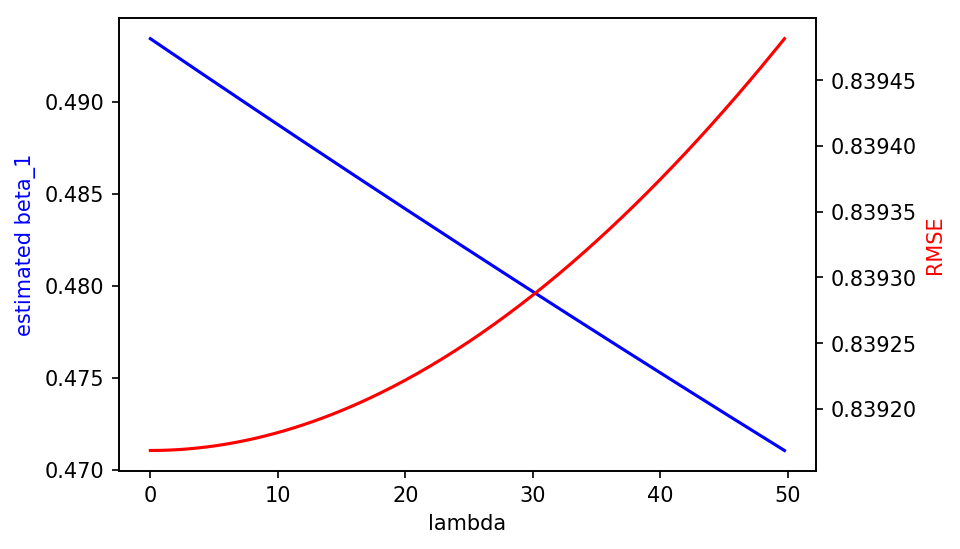

In [8]:
res = list()
for lam in np.arange(0, 50, 0.25):
    beta = ox.linreg_ridge_lu(y, X, lam)
    rmse = ox.linreg_rmse(y, X, beta)
    res.append((lam, beta[1], rmse))

res = np.array(res)
_,ax1 = plt.subplots(dpi=dpi)
ax1.plot(res[:,0], res[:,1], 'b-');
ax1.set_xlabel('lambda');
ax1.set_ylabel('estimated beta_1', color='b');
ax2 = ax1.twinx()
ax2.plot(res[:,0], res[:,2], 'r-');
ax2.set_ylabel('RMSE', color='r');

However, this does not hold true in a two-way data split where the RMSE is computed on the out-of-sample set (validation set). There seems to exit an optimal 

$$
\lambda_{optimal} = \arg\min \, RMSE(\lambda)
$$ 

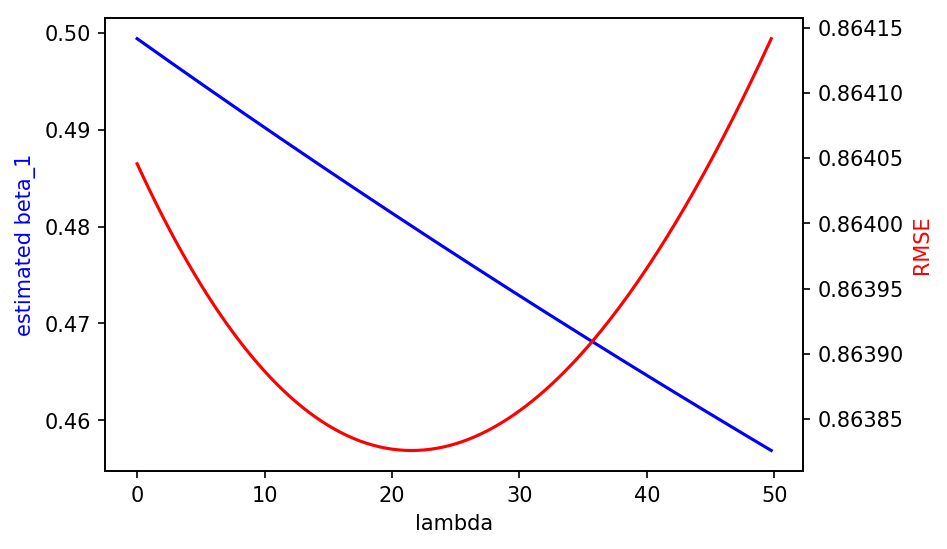

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

res = list()
for lam in np.arange(0, 50, 0.25):
    beta = ox.linreg_ridge_lu(y_train, X_train, lam)
    rmse = ox.linreg_rmse(y_test, X_test, beta)
    res.append((lam, beta[1], rmse))

res = np.array(res)
_,ax1 = plt.subplots(dpi=dpi)
ax1.plot(res[:,0], res[:,1], 'b-');
ax1.set_xlabel('lambda');
ax1.set_ylabel('estimated beta_1', color='b');
ax2 = ax1.twinx()
ax2.plot(res[:,0], res[:,2], 'r-');
ax2.set_ylabel('RMSE', color='r');